In [34]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd() / "notebooks"))  # so we can import _utils from notebooks/

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from _utils import get_data_dir

DATA_DIR = get_data_dir()
DATA_DIR


WindowsPath('C:/Users/AdamR/OneDrive/UCSB/VIU/HonorsThesis/data')

In [35]:
ROOT = DATA_DIR  # assumes DATA_DIR is already defined
folders = ["50_50", "80_20", "100_0"]

# Combine human CSVs from each condition folder
human_master = pd.concat(
    [pd.read_csv(ROOT / f / "human_data.csv") for f in folders],
    ignore_index=True
)

# Map condition codes
human_master["condition"] = human_master["condition"].map({
    "condition_1": "80_20",
    "condition_2": "50_50",
    "condition_3": "100_0"
})

# Keep / order desired columns
cols = [
    "stimID", "condition", "response", "side_selected", "cue_points",
    "line1_angle", "line2_angle", "valid_cue", "TP", "participantID"
]
human_master = human_master[cols]
human_master["decision"] = (human_master["response"] >= 4).astype(int)

display(human_master)


,stimID,condition,response,side_selected,cue_points,line1_angle,line2_angle,valid_cue,TP,participantID,decision
0,100,50_50,6,1,2,14.314827,1.921956,False,True,SA,1
1,845,50_50,5,1,2,15.054317,4.222230,False,True,SA,1
2,245,50_50,4,1,1,14.314827,6.508956,True,True,SA,1
3,72,50_50,4,2,2,8.775056,15.054317,True,True,SA,1
4,469,50_50,4,2,2,4.222230,19.885165,True,True,SA,1
...,...,...,...,...,...,...,...,...,...,...,...
35995,698,100_0,5,1,1,11.159944,6.508956,True,False,BC,1
35996,910,100_0,5,1,2,9.651833,4.986334,False,False,BC,1
35997,880,100_0,5,2,2,4.222230,8.775056,True,False,BC,1
35998,53,100_0,5,2,2,4.986334,11.908300,True,False,BC,1


In [36]:
def sdt_metrics(g):
    n = len(g)
    tp1 = g["TP"] == 1
    tp0 = ~tp1
    resp1 = g["decision"] == 1

    hits    = (resp1 & tp1).sum()
    fas     = (resp1 & tp0).sum()
    correct = hits + ((~resp1) & tp0).sum()

    hit_rate = hits / tp1.sum()
    fa_rate  = fas  / tp0.sum()
    accuracy = correct / n

    eps_H = 1 / (2 * tp1.sum())
    eps_F = 1 / (2 * tp0.sum())
    H = min(max(hit_rate, eps_H), 1 - eps_H)
    F = min(max(fa_rate,  eps_F), 1 - eps_F)

    dprime    = norm.ppf(H) - norm.ppf(F)
    criterion = -0.5 * (norm.ppf(H) + norm.ppf(F))

    return pd.Series({
        "n_trials": n,
        "accuracy": accuracy,
        "hit_rate": hit_rate,
        "fa_rate": fa_rate,
        "dprime": dprime,
        "criterion": criterion,
    })

human_participant_metrics = (
    human_master
    .groupby(["participantID", "condition"])
    .apply(sdt_metrics)
    .reset_index()
)

human_participant_metrics.to_csv(ROOT / "human_participant_metrics.csv", index=False)
human_participant_metrics.head()

C:\Users\AdamR\AppData\Local\Temp\ipykernel_16076\3310196464.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(sdt_metrics)


,participantID,condition,n_trials,accuracy,hit_rate,fa_rate,dprime,criterion
0,AG,100_0,1000.0,0.775,0.882,0.332,1.619441,-0.375323
1,AG,50_50,1000.0,0.704,0.922,0.514,1.383554,-0.726877
2,AG,80_20,1000.0,0.507,0.670,0.656,0.038342,-0.420742
3,AW,100_0,1000.0,0.657,0.744,0.430,0.832101,-0.239676
4,AW,50_50,1000.0,0.595,0.630,0.440,0.482823,-0.090442


In [37]:
from scipy.stats import norm
import pandas as pd
import numpy as np

# thresholds (easily changeable)
POS_CONF = 6  # "sure present"
NEG_CONF = 1  # "sure absent"

def sdt_from_binary(decisions, TPs):
    n = len(decisions)
    tp1 = TPs == 1
    tp0 = ~tp1
    resp1 = decisions == 1

    hits    = (resp1 & tp1).sum()
    fas     = (resp1 & tp0).sum()
    correct = hits + ((~resp1) & tp0).sum()

    hit_rate = hits / tp1.sum()
    fa_rate  = fas  / tp0.sum()
    accuracy = correct / n

    eps_H = 1 / (2 * tp1.sum())
    eps_F = 1 / (2 * tp0.sum())
    H = min(max(hit_rate, eps_H), 1 - eps_H)
    F = min(max(fa_rate,  eps_F), 1 - eps_F)

    dprime    = norm.ppf(H) - norm.ppf(F)
    criterion = -0.5 * (norm.ppf(H) + norm.ppf(F))
    return accuracy, hit_rate, fa_rate, dprime, criterion

rows = []

for cond, df_c in human_master.groupby("condition"):
    g = df_c.groupby("stimID")

    # Aggregate once per stimID
    agg = g.agg(
        max_resp=("response", "max"),
        min_resp=("response", "min"),
        mean_decision=("decision", "mean"),
        TP=("TP", "first")
    )

    # Base majority
    maj_decisions = (agg["mean_decision"] > 0.5).astype(int)

    # Majority with positive exception: any response >= POS_CONF → 1
    pos_excisions = np.where(agg["max_resp"] >= POS_CONF, 1, maj_decisions)

    # Majority with negative exception: any response <= NEG_CONF → 0
    neg_excisions = np.where(agg["min_resp"] <= NEG_CONF, 0, maj_decisions)

    TPs = agg["TP"].astype(bool).values

    for name, decisions in [
        ("majority", maj_decisions.values),
        ("maj_pos_exception", pos_excisions),
        ("maj_neg_exception", neg_excisions),
    ]:
        acc, H, F, d, c = sdt_from_binary(decisions, TPs)
        rows.append({
            "aggregation": name,
            "condition": cond,
            "n_trials": len(decisions),
            "accuracy": acc,
            "hit_rate": H,
            "fa_rate": F,
            "dprime": d,
            "criterion": c,
        })

human_agg = pd.DataFrame(rows)
human_agg.to_csv(ROOT / "human_aggregation_metrics.csv", index=False)
human_agg


,aggregation,condition,n_trials,accuracy,hit_rate,fa_rate,dprime,criterion
0,majority,100_0,1000,0.781,0.844,0.282,1.587945,-0.217062
1,maj_pos_exception,100_0,1000,0.710,0.976,0.556,1.836533,-1.059102
2,maj_neg_exception,100_0,1000,0.647,0.398,0.104,1.000557,0.758806
3,majority,50_50,1000,0.682,0.732,0.368,0.956028,-0.140859
4,maj_pos_exception,50_50,1000,0.593,0.936,0.750,0.847546,-1.098263
5,maj_neg_exception,50_50,1000,0.594,0.292,0.104,0.711533,0.903318
6,majority,80_20,1000,0.665,0.768,0.438,0.888318,-0.288117
7,maj_pos_exception,80_20,1000,0.627,0.924,0.670,0.992590,-0.936208
8,maj_neg_exception,80_20,1000,0.688,0.508,0.132,1.137041,0.548466


In [39]:
import numpy as np
import pandas as pd
from scipy.stats import norm

conds = human_master["condition"].unique()

def sdt_metrics(decision, TP):
    decision, TP = np.asarray(decision), np.asarray(TP)
    acc = (decision == TP).mean()
    hit = (decision[TP == 1] == 1).mean()
    fa  = (decision[TP == 0] == 1).mean()
    eps = 1e-5
    hit = np.clip(hit, eps, 1 - eps)
    fa  = np.clip(fa,  eps, 1 - eps)
    zH, zF = norm.ppf(hit), norm.ppf(fa)
    dprime = zH - zF
    c = -0.5 * (zH + zF)
    return acc, hit, fa, dprime, c

best_rows = []
for cond in conds:
    dfc = human_master[human_master["condition"] == cond]
    stats = []
    for pid, dfg in dfc.groupby("participantID"):
        stats.append((pid, *sdt_metrics(dfg["decision"], dfg["TP"])))
    pid, acc, hit, fa, dp, c = max(stats, key=lambda x: x[1])
    best_rows.append(dict(
        aggregation="best_individual",
        condition=cond,
        n_trials=len(dfc),
        accuracy=acc,
        hit_rate=hit,
        fa_rate=fa,
        dprime=dp,
        criterion=c
    ))

def wlc_for_condition(dfc):
    piv = dfc.pivot_table(index="stimID", columns="participantID", values="response")
    X = piv.values
    Xc = X - X.mean(axis=0, keepdims=True)
    trials = dfc.drop_duplicates("stimID").sort_values("stimID")
    TP = trials["TP"].values
    mu_s = Xc[TP == 1].mean(axis=0)
    mu_n = Xc[TP == 0].mean(axis=0)
    dmu = mu_s - mu_n
    Sigma = np.cov(Xc, rowvar=False)
    lam = 1e-3
    w = np.linalg.solve(Sigma + lam * np.eye(Sigma.shape[0]), dmu)
    dv = Xc @ w
    ths = np.linspace(dv.min(), dv.max(), 200)
    best_acc, best_t = -1, 0
    for t in ths:
        pred = (dv > t).astype(int)
        acc = (pred == TP).mean()
        if acc > best_acc:
            best_acc, best_t = acc, t
    pred = (dv > best_t).astype(int)
    acc, hit, fa, dp, c = sdt_metrics(pred, TP)
    return acc, hit, fa, dp, c, len(piv)

wlc_rows = []
for cond in conds:
    dfc = human_master[human_master["condition"] == cond]
    acc, hit, fa, dp, c, ntr = wlc_for_condition(dfc)
    wlc_rows.append(dict(
        aggregation="WLC",
        condition=cond,
        n_trials=ntr,
        accuracy=acc,
        hit_rate=hit,
        fa_rate=fa,
        dprime=dp,
        criterion=c
    ))

human_agg = pd.concat([human_agg, pd.DataFrame(best_rows + wlc_rows)], ignore_index=True)
display(human_agg)

,aggregation,condition,n_trials,accuracy,hit_rate,fa_rate,dprime,criterion
0,majority,100_0,1000,0.781,0.844,0.282,1.587945,-0.217062
1,maj_pos_exception,100_0,1000,0.710,0.976,0.556,1.836533,-1.059102
2,maj_neg_exception,100_0,1000,0.647,0.398,0.104,1.000557,0.758806
3,majority,50_50,1000,0.682,0.732,0.368,0.956028,-0.140859
4,maj_pos_exception,50_50,1000,0.593,0.936,0.750,0.847546,-1.098263
5,maj_neg_exception,50_50,1000,0.594,0.292,0.104,0.711533,0.903318
6,majority,80_20,1000,0.665,0.768,0.438,0.888318,-0.288117
7,maj_pos_exception,80_20,1000,0.627,0.924,0.670,0.992590,-0.936208
8,maj_neg_exception,80_20,1000,0.688,0.508,0.132,1.137041,0.548466
9,best_individual,50_50,12000,0.704,0.922,0.514,1.383554,-0.726877


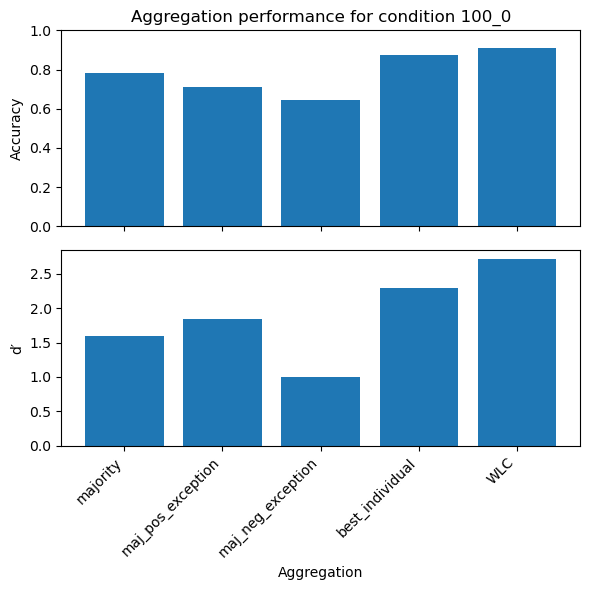

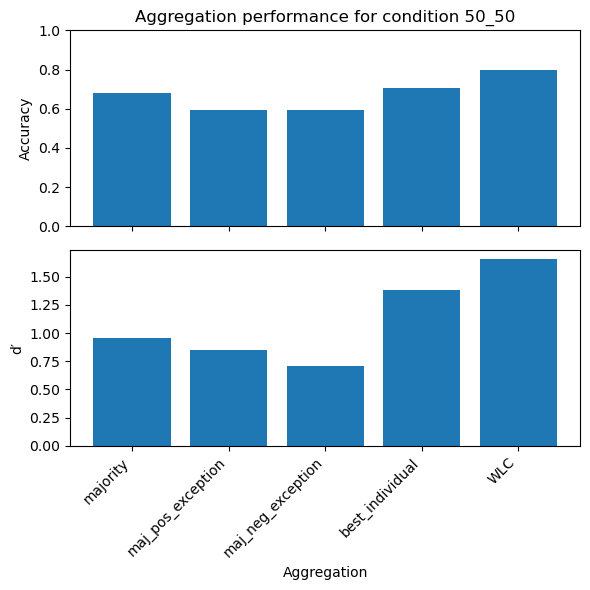

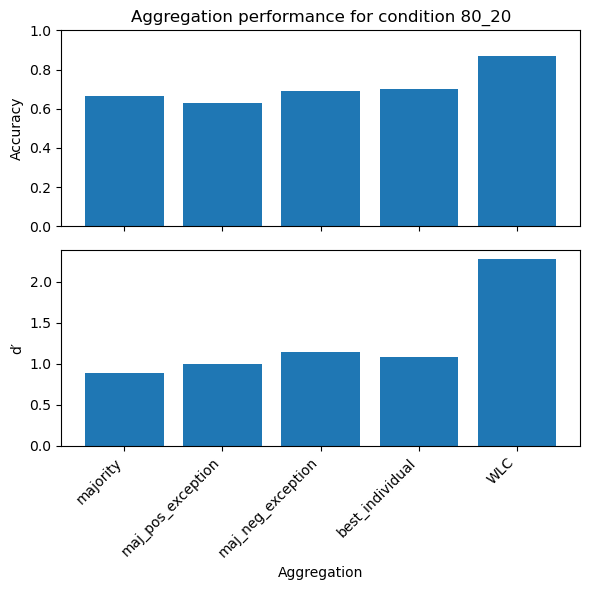

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Assume `human_agg` has columns:
# aggregation, condition, accuracy, hit_rate, fa_rate, dprime, criterion

conditions = human_agg["condition"].unique()

for cond in conditions:
    dfc = human_agg[human_agg["condition"] == cond]
    aggs = dfc["aggregation"].tolist()
    
    # Example: plot accuracy and dprime as two stacked subplots per condition
    x = np.arange(len(aggs))
    
    fig, axes = plt.subplots(2, 1, figsize=(6, 6), sharex=True)
    
    # --- Accuracy ---
    axes[0].bar(x, dfc["accuracy"].values)
    axes[0].set_ylabel("Accuracy")
    axes[0].set_title(f"Aggregation performance for condition {cond}")
    axes[0].set_ylim(0, 1)  # accuracy between 0 and 1
    
    # --- d' ---
    axes[1].bar(x, dfc["dprime"].values)
    axes[1].set_ylabel("d′")
    axes[1].set_xlabel("Aggregation")
    axes[1].set_xticks(x)
    axes[1].set_xticklabels(aggs, rotation=45, ha="right")
    
    plt.tight_layout()
    plt.show()
